In [1]:
import os
print(f"Current Directory: {os.getcwd()}")
os.chdir("..")
print(f"New Directory: {os.getcwd()}")

Current Directory: c:\Users\mattc\Documents\DL-reservoir-modeling\experiments
New Directory: c:\Users\mattc\Documents\DL-reservoir-modeling


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from math import floor
import os
import copy
from tqdm import tqdm

from src.data.data_processing import *
from src.data.data_fetching import *
from src.models.model_zoo import *
from src.models.predict_model import *
from src.models.train_model import *

In [3]:
# GRanD Attributes
import geopandas as gpd
gdf = gpd.read_file("data/GRanD/GRanD_dams_v1_3.shp")
gdf = gdf.drop(columns="geometry").set_index("GRAND_ID")

# Main reservoir use
use_ohe = pd.get_dummies(gdf['MAIN_USE'], prefix='USE', dtype='float')

# DOR category (low, med, high)
gdf['dor_cat'] = pd.cut(gdf['DOR_PC'], bins=[0, 50, 100, np.inf], labels=['Low', 'Medium', 'High'])
dor_ohe = pd.get_dummies(gdf['dor_cat'], prefix='DOR', dtype='float')

attribute_df = pd.concat([use_ohe, dor_ohe], axis=1)
attribute_df.index = attribute_df.index.astype(str)
attribute_df.head()

,USE_Fisheries,USE_Flood control,USE_Hydroelectricity,USE_Irrigation,USE_Navigation,USE_Other,USE_Recreation,USE_Water supply,DOR_Low,DOR_Medium,DOR_High
GRAND_ID,,,,,,,,,,,
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
5,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [4]:
def get_device():
    # Check for MPS (Apple Silicon)
    if torch.backends.mps.is_available() and torch.backends.mps.is_built():
        return torch.device("mps")
    
    # Check for CUDA
    elif torch.cuda.is_available():
        return torch.device("cuda")
    
    # Default to CPU
    else:
        return torch.device("cpu")

In [5]:
def get_left_years(res_list):
    """ 
    Get left data window years (first record year after leading NA) for each reservoir ID in res_list.
    Return results as dictionary
    Params:
    res_list -- list of ResOPS ID's to fetch left years for
    """
    # For each filtered reservoir, find first year of avail record after leading NA (left year window)
    left_years_dict = {}
    for res in res_list:
        left_years_dict[res] = resops_fetch_data(res_id=res, 
                                                vars=['inflow', 'outflow', 'storage']).isna().idxmin().max().year
    return left_years_dict

In [6]:
def data_processing(res_id, transform_type, left, right='2020-12-31', train_frac=0.6, val_frac=0.2, test_frac=0.2, return_scaler=False, storage=False, attributes=None):
    """
    Run data processing pipeline for one ResOPS reservoir.
    Params:
    res_id -- int, ResOPS reservoir ID
    transform_type -- str, in preprocessing, whether to 'standardize' or 'normalize' the data
    left -- str (YYYY-MM-DD), beginning boundary of time window
    right -- str (YYYY-MM-DD), end boundary of time window
    return_scaler -- bool, whether or not to return src.data.data_processing.time_scaler() object
    storage -- bool, whether or not to include storage data in features
    attributes -- pd.DataFrame, dataframe of one-hot encoded reservoir attributes to include as features
    """

    # Read in data, columns are [inflow, outflow, storage]
    df = resops_fetch_data(res_id=res_id, vars=['inflow', 'outflow', 'storage'])
    # Add day of the year (doy) as another column
    df['doy'] = df.index.to_series().dt.dayofyear.astype('float')
    # Add reservoir attributes if provided
    if attributes is not None:
        attr = attributes.loc[[res_id]]
        attr = pd.concat([attr]*len(df), ignore_index=True)
        attr.index = df.index
        df = pd.concat([df, attr], axis=1)
    # Select data window
    df = df[left:right].copy()

    # Get input feature column indices (including one-hot attribute features if provided)
    base_input_cols = ['inflow', 'doy'] + (['storage'] if storage else [])
    is_binary = df.apply(lambda c: set(pd.unique(c.dropna())) <= {0, 1})
    one_hot_cols = [c for c, b in is_binary.items() if b and c not in base_input_cols and c != 'outflow']
    input_idx = [df.columns.get_loc(c) for c in (base_input_cols + one_hot_cols)]

    # Get output target column index
    target_idx = [df.columns.get_loc('outflow')]


    # Run data processing pipeline
    pipeline = processing_pipeline(train_frac=train_frac, val_frac=val_frac, test_frac=test_frac, chunk_size=3*365, pad_value=-1, transform_type=transform_type, fill_na_method='mean')
    # Train/val/test tensors of shape (#chunks, chunksize, [inflow, outflow, storage, doy])
    ts_train, ts_val, ts_test = pipeline.process_data(df) 

    # Separate inputs(X) and targets (y)
    X_train, X_val, X_test = ts_train[:, :, input_idx], ts_val[:, :, input_idx], ts_test[:, :, input_idx]
    y_train, y_val, y_test = ts_train[:, :, target_idx], ts_val[:, :, target_idx], ts_test[:, :, target_idx]

    if return_scaler:
        return (X_train, y_train), (X_val, y_val), (X_test, y_test), pipeline.scaler
    else:
        return (X_train, y_train), (X_val, y_val), (X_test, y_test)

In [7]:
class multi_reservoir_data_oos:
    """Store and combine data from multiple in sample and out of sample reservoirs"""
    def __init__(self, left_years_dict, res_list, oos_list, attributes=None):
        """ 
        Params:
        left_years_dict: dict, dictionary of year of first available data from each requested reservoir (name : year)
        res_list: list of ResOps reservoir ID's of interest
        oos_list: list of out-of-sample ResOps reservoir ID's (subset of res_list)
        attributes: pd.DataFrame, dataframe of one-hot encoded reservoir attributes to include as features
        """
        self.left_years_dict = left_years_dict
        self.res_list = res_list
        self.oos_list = oos_list # out of sample reservoirs
        self.is_list = [item for item in res_list if item not in oos_list] # in sample reservoirs
        self.attributes = attributes

        # For in-sample reservoirs: collect train and val tensors and their respective src.data.data_processing.time_scaler() objects
        self.X_train_dict = {}
        self.y_train_dict = {}
        self.X_val_dict = {}
        self.y_val_dict = {}
        self.scaler_dict_is = {}

        # For out-of-sample reservoirs: collect test tensors (full history) and their respective src.data.data_processing.time_scaler() objects
        self.X_test_dict = {}
        self.y_test_dict = {}
        self.scaler_dict_oos = {}
        return
    
    def fetch_data(self):
        """Fetch data for each reservoir. For in-sample reservoirs: split into train/val tensors. For oos reservors: reshape data into test tensors"""
        # Run data processing for each reservoir
        for reservoir, left_year in tqdm(self.left_years_dict.items(), desc='Processing data: '):
            # Out-of-sample reservoirs
            if reservoir in self.oos_list:
                result = data_processing(res_id=reservoir, transform_type='standardize', train_frac=1, val_frac=0, test_frac=0,
                                    left=f'{left_year}-01-01', right='2020-12-31',
                                    return_scaler=True, attributes=self.attributes)
                self.X_test_dict[reservoir] = result[0][0]
                self.y_test_dict[reservoir] = result[0][1]
                self.scaler_dict_is[reservoir] = result[3]

            # In-sample reservoirs
            else:
                result = data_processing(res_id=reservoir, transform_type='standardize', train_frac=0.75, val_frac=0.25, test_frac=0,
                                        left=f'{left_year}-01-01', right='2020-12-31',
                                        return_scaler=True, attributes=self.attributes)
                # Save results
                self.X_train_dict[reservoir] = result[0][0] # (# chunks, chunk size, # features (e.g. inflow and doy))
                self.y_train_dict[reservoir] = result[0][1] # (# chunks, chunk size, 1 (outflow))
                self.X_val_dict[reservoir] = result[1][0]
                self.y_val_dict[reservoir] = result[1][1]
                self.scaler_dict_oos[reservoir] = result[3]
        return
    
    def combine_reservoir_data(self):
        """ 
        Concatenate all fetched reservoir data into one train, val, test tensor
        """
        # Concat tensors along chunks dimension (dim = 0)
        X_train, y_train = torch.cat([self.X_train_dict[key] for key in self.is_list], dim=0), torch.cat([self.y_train_dict[key] for key in self.is_list], dim=0)
        X_val, y_val = torch.cat([self.X_val_dict[key] for key in self.is_list], dim=0), torch.cat([self.y_val_dict[key] for key in self.is_list], dim=0)
        X_test, y_test = torch.cat([self.X_test_dict[key] for key in self.oos_list], dim=0), torch.cat([self.y_test_dict[key] for key in self.oos_list], dim=0)

        return (X_train, y_train), (X_val, y_val), (X_test, y_test)
    
    def fetch_and_combine(self):
        """Run fetch_data and return combined tensors"""
        self.fetch_data()
        return self.combine_reservoir_data()

In [8]:
def train_simultaneous_model(X_train, y_train, X_val, y_val, plot=False, device=torch.device("cpu")):
    """
    Train simultanoues LSTM model on in-sample reservoirs
    Params:
    X_train/X_val -- train/val input tensors of shape (# batches, batch size, # features)
    y_train/y_val -- train/val target tensors of shape (# batches, batch size, 1)
    plot -- bool, whether or not to plot train/val losses
    """
    # Create PyTorch Dataset and Dataloader from training and validation for in-sample reservoirs
    dataset_train, dataset_val = (TensorDataset(X_train, y_train), TensorDataset(X_val, y_val))
    dataloader_train, dataloader_val = (DataLoader(dataset_train, batch_size=32, shuffle=False), 
                                        DataLoader(dataset_val, batch_size=32, shuffle=False))
    # Instantiate model (Model 1a archeticture)
    input_size = X_train.shape[2]
    hidden_size1 = 30
    hidden_size2 = 15
    output_size = 1
    dropout_prob = 0.3
    num_layers = 1
    torch.manual_seed(0)
    model = LSTMModel1_opt(input_size=input_size, hidden_size1=hidden_size1, 
                                hidden_size2=hidden_size2, output_size=output_size, num_layers=num_layers, dropout_prob=dropout_prob)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001)

    # Run training loop
    train_losses, val_losses = training_loop(model=model, criterion=criterion, optimizer=optimizer, 
                                            patience=10, dataloader_train=dataloader_train, 
                                            dataloader_val=dataloader_val, epochs=1000, device=device)
    if plot:
        plt.figure()
        plot_train_val(train_losses=train_losses, val_losses=val_losses)
        plt.show()

    return model

In [9]:
def r2_score_tensor(model, X, y):
    """
    Evaluate r2 score.
    X -- input tensor of shape (# batches, batch size, # features)
    y -- target tensor of shape (# batches, batch size, 1)
    """
    # Get predictions
    y_hat = predict(model, X)
    # Flatten and remove padding values
    y_hat, y = flatten_rm_pad(y_hat=y_hat, y=y)
    # Find R2
    r2 = r2_score(y_pred=y_hat, y_true=y)
    return r2

In [10]:
def main():
    # Set the device
    device = get_device()
    print(f"Using device: {device}")

    # Get list of reservoir ID of interest
    res_list = filter_res()

    # Randomly choose out of sample reservoirs
    np.random.seed(0)
    oos_list = np.random.choice(a=res_list, size=round(0.2 * len(res_list)), replace=False)

    # Get left window years
    left_years_dict = get_left_years(res_list=res_list)

    # Data collection and processing
    data_combiner = multi_reservoir_data_oos(left_years_dict=left_years_dict, res_list=res_list, oos_list=oos_list, attributes=attribute_df)
    data_result = data_combiner.fetch_and_combine()

    # Train in-sample reservoirs simultaneously
    simul_model = train_simultaneous_model(X_train=data_result[0][0], y_train=data_result[0][1],
                                           X_val=data_result[1][0], y_val=data_result[1][1], plot=True, device=device)
    
    # Save model
    torch.save(simul_model.state_dict(), 'src/models/saved_models/resops_simul_model.pt')
    
    # Evaluate and save in-sample performance
    simul_model.to(torch.device("cpu")) # move model to CPU for evaluation
    r2_in_sample_df = pd.DataFrame(index=data_combiner.is_list, columns=['train', 'val'])
    for in_res in tqdm(data_combiner.is_list, desc='Evaluating in-sample performance: '):
        r2_in_sample_df.loc[in_res, :] = [r2_score_tensor(model=simul_model, X=data_combiner.X_train_dict[in_res], 
                                                          y=data_combiner.y_train_dict[in_res]),
                                          r2_score_tensor(model=simul_model, X=data_combiner.X_val_dict[in_res], 
                                                          y=data_combiner.y_val_dict[in_res])]
    r2_in_sample_df.to_csv('report/results/resops_training/resops_oos_in_sample_train_val.csv')

    # Evaluate and save out-of-sample performance
    r2_out_sample_df = pd.DataFrame(index=data_combiner.oos_list, columns=['test'])
    for out_res in tqdm(data_combiner.oos_list, desc='Evaluating out-of-sample performance: '):
        r2_out_sample_df.loc[out_res, :] = r2_score_tensor(model=simul_model, X=data_combiner.X_test_dict[out_res], y=data_combiner.y_test_dict[out_res])
    r2_out_sample_df.to_csv('report/results/resops_training/resops_oos_out_of_sample_test.csv')

    return

Using device: cuda


Training epochs:  69%|██████▉   | 688/1000 [00:56<00:25, 12.18it/s]


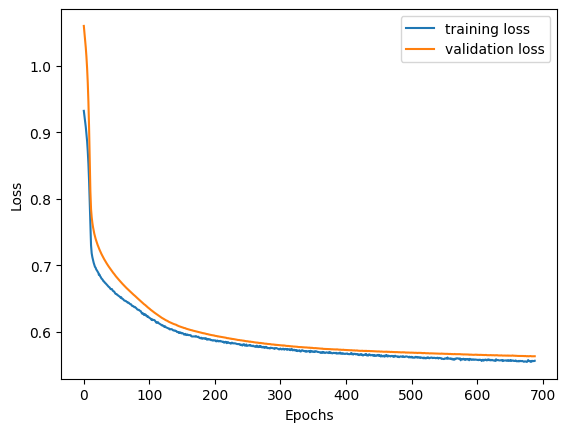

Evaluating out-of-sample performance: 100%|██████████| 23/23 [00:00<00:00, 234.15it/s]


In [11]:
main()